
SumSquares: 2D


In [ ]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=713c6b79236ce4fdfd1e063f16bddb9d0f3dc6b68b785d23269dd19fb24aaedd
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [ ]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 20
opt = True

In [ ]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [ ]:
n_start_AcqFunc = iters #multi-start iterations to avoid local optima in AcqFunc optimization


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [ ]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [ ]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [ ]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [ ]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
start_approx = time.time()
start_approx


1649162347.3936346

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65955991  4.40648987]	 -41.5884450098667	 -5.468172821636052	    
init	 [-9.9977125  -3.95334855]	 -131.21218477957908	 -5.468172821636052	    
init	 [-7.06488218 -8.1532281 ]	 -182.86281732102734	 -5.468172821636052	    
init	 [-6.27479577 -3.08878546]	 -58.4542532110911	 -5.468172821636052	    
init	 [-2.06465052  0.77633468]	 -5.468172821636052	 -5.468172821636052	    
1  	 [ 7.89213327 -8.29911577]	 -200.03641276683908	 -5.468172821636052	 -5.470068425465989
2  	 [7.66612182 2.47344414]	 -71.00527566059496	 -5.468172821636052	 -5.470068425465989
3  	 [1.62717855 9.40039978]	 -179.3827421328839	 -5.468172821636052	 -5.470068425465989
4  	 [-9.56950389  8.95940422]	 -252.11725289788865	 -5.468172821636052	 -5.470068425465989
5  	 [ 2.56152397 -4.28847437]	 -43.34342980630102	 -5.468172821636052	 -5.47006840364817
6  	 [ -1.05892337 -10.        ]	 -201.1213186930317	 -5.468172821636052	 -5.4700

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.28010196 -9.48147536]	 -181.43541115584648	 -4.333099000920773	    
init	 [ 0.99324956 -1.29355215]	 -4.333099000920773	 -4.333099000920773	    
init	 [-1.59264396 -3.39330358]	 -25.565533148780872	 -4.333099000920773	    
init	 [-5.90702732  2.38541933]	 -46.27342248166184	 -4.333099000920773	    
init	 [-4.00690653 -4.6634545 ]	 -59.55091562094812	 -4.333099000920773	    
1  	 [4.01504693 9.2910216 ]	 -188.7667666769868	 -4.333099000920773	 -4.343843863435749
2  	 [ 9.4582138 -7.7444757]	 -209.411615827435	 -4.333099000920773	 -4.343843863435749
3  	 [ 9.07319925 -1.03970567]	 -84.48492034594878	 -4.333099000920773	 -4.343843846857654
4  	 [-9.13741927 -7.85625192]	 -206.93381928482216	 -4.333099000920773	 -4.3438435201435155
5  	 [9.5985819  6.97740137]	 -189.5010342975437	 -4.333099000920773	 -4.34384277659516
6  	 [-3.25263411  9.0402141 ]	 -174.03057068772284	 -4.333099000920773	 -4.343843

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.01595805 4.16295645]	 -35.692583610916834	 -17.582120911078754	    
init	 [-4.18190522  0.2165521 ]	 -17.582120911078754	 -17.582120911078754	    
init	 [7.85893909 7.92586178]	 -187.4014934415638	 -17.582120911078754	    
init	 [-7.48829379 -5.85514244]	 -124.63992981683481	 -17.582120911078754	    
init	 [-8.97065593 -1.18380313]	 -83.2754475728413	 -17.582120911078754	    
1  	 [ 5.60629529 -3.87272935]	 -61.42661215628989	 -17.582120911078754	 -17.582120911078754
2  	 [-6.2437035   9.04202486]	 -202.50026057521436	 -17.582120911078754	 -17.582120911078754
3  	 [ 0.20293337 10.        ]	 -200.0411819510794	 -17.582120911078754	 -17.58212033823383
4  	 [-0.42169096 -8.75441039]	 -153.45722588114134	 -17.582120911078754	 -17.582120911078754
5  	 [ 8.49805726 -8.91732988]	 -231.2545217289155	 -17.582120911078754	 -17.582119513046617
6  	 [-9.21277105  4.93342182]	 -133.55245206852663	 -17.5821209

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.34059678 0.94464498]	 -89.0314565014143	 -27.80880071439404	    
init	 [9.4536872  4.29631987]	 -126.28893057280868	 -27.80880071439404	    
init	 [ 3.95457649 -5.67821009]	 -80.12281484649141	 -27.80880071439404	    
init	 [ 9.5254891 -9.8753949]	 -285.78179120922215	 -27.80880071439404	    
init	 [-4.94035275 -1.30416935]	 -27.80880071439404	 -27.80880071439404	    
1  	 [-6.35109191  8.36766078]	 -180.3718623830372	 -27.80880071439404	 -27.80880071439404
2  	 [ -4.8985823 -10.       ]	 -223.99610851724944	 -27.80880071439404	 -27.80880071439404
3  	 [2.73697346 9.11609188]	 -173.69728602361354	 -27.80880071439404	 -27.808800714393946
4	 [0.97610237 1.99594982]	 -8.92040722633793	 -8.92040722633793	 -27.808800712709687
5  	 [-10.           3.33491649]	 -122.24333601759977	 -8.92040722633793	 -8.920408544915757
6  	 [-10.          -3.66629598]	 -126.88345235298578	 -8.92040722633793	 -8.92040655

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.56013658  7.41464612]	 -140.86907304317228	 -10.04307293518387	    
init	 [-5.86561689  8.37221816]	 -174.59353533361667	 -10.04307293518387	    
init	 [-0.23177622  2.23487726]	 -10.04307293518387	 -10.04307293518387	    
init	 [5.31815713 0.36835976]	 -28.554173077012745	 -10.04307293518387	    
init	 [-4.06398997 -6.24557543]	 -94.53043928694063	 -10.04307293518387	    
1  	 [9.27861058 9.20453431]	 -255.5395178906315	 -10.04307293518387	 -10.043073030426035
2  	 [ 8.87080164 -7.76615146]	 -199.31733862713008	 -10.04307293518387	 -10.043073030426035
3  	 [0.54357666 9.2242228 ]	 -170.4680482407008	 -10.04307293518387	 -10.043072892838797
4  	 [ 2.49508934 -6.80638133]	 -98.87912454627462	 -10.04307293518387	 -10.043072918396797
5  	 [-10.         -8.9060044]	 -258.63382876957485	 -10.04307293518387	 -10.043072999795678
6  	 [-8.62367183  0.50898962]	 -74.88585667581904	 -10.04307293518387	 -1

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 7.85720303 -3.36040389]	 -84.32026809583151	 -5.629416961321397	    
init	 [ 6.42458246 -9.16606749]	 -209.30884609749882	 -5.629416961321397	    
init	 [-7.8468664   1.90104128]	 -68.80122824744078	 -5.629416961321397	    
init	 [ 0.59634724 -1.62385143]	 -5.629416961321397	 -5.629416961321397	    
init	 [-3.29184301  2.45038864]	 -22.84503944485431	 -5.629416961321397	    
1  	 [4.34664291 8.74699069]	 -171.91299695999675	 -5.629416961321397	 -5.6308656614916455
2  	 [-4.96771714 -9.17248997]	 -192.94735819477367	 -5.629416961321397	 -5.6308656614916455
3  	 [9.57427611 1.74148842]	 -97.73232691305284	 -5.629416961321397	 -5.6308656614916455
4  	 [-5.6935267   8.60486508]	 -180.50365249520243	 -5.629416961321397	 -5.630865657108705
5  	 [-10.          -5.66019356]	 -164.0755823122173	 -5.629416961321397	 -5.630865022401466
6  	 [3.82796271 2.69284027]	 -29.156075898516452	 -5.629416961321397	 -5

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.47383421  5.59837584]	 -134.48949046062052	 -21.448213419349443	    
init	 [-1.23181537  4.46930356]	 -41.46671767109191	 -21.448213419349443	    
init	 [9.55979024 0.76991741]	 -92.57513506242564	 -21.448213419349443	    
init	 [ 0.02240927 -8.55897733]	 -146.51268814245697	 -21.448213419349443	    
init	 [-4.63122040e+00 -2.34998349e-03]	 -21.448213419349443	 -21.448213419349443	    
1  	 [ 8.12846538 -6.39096762]	 -147.76088362344177	 -21.448213419349443	 -21.448213419349443
2  	 [ 4.06516126 10.        ]	 -216.52553605840973	 -21.448213419349443	 -21.448213419349443
3  	 [-9.10467478 -9.8356699 ]	 -276.3759076385656	 -21.448213419349443	 -21.448213419349443
4  	 [-7.86246511 -2.61028169]	 -75.44549865130998	 -21.448213419349443	 -21.448213419349443
5	 [3.63197518 0.86181451]	 -14.676692185809095	 -14.676692185809095	 -21.448212113836206
6  	 [-3.16848977  9.87018565]	 -204.88045702297123	 -1

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.46858806 9.37081326]	 -231.40408972112363	 -0.5791878792948744	    
init	 [7.3838908  0.61711383]	 -55.28350237060649	 -0.5791878792948744	    
init	 [-5.34543344 -9.77202391]	 -219.5585614355461	 -0.5791878792948744	    
init	 [-1.39062363 -1.9529728 ]	 -9.562039601098967	 -0.5791878792948744	    
init	 [ 0.45349343 -0.43216408]	 -0.5791878792948744	 -0.5791878792948744	    
1  	 [ 9.69498875 -9.42535902]	 -271.6675921188219	 -0.5791878792948744	 -1.1207038744027513
2  	 [-9.83383251  5.77166529]	 -163.3285022998636	 -0.5791878792948744	 -1.1207038744027513
3  	 [-3.97152767  9.51013426]	 -196.65833950916016	 -0.5791878792948744	 -1.1207038728081333
4  	 [-9.65586204 -5.07440767]	 -144.73489822426617	 -0.5791878792948744	 -1.1207037739007804
5  	 [1.10947828 5.5318851 ]	 -62.4344475515165	 -0.5791878792948744	 -1.1207038181863198
6  	 [ 3.77011518 -4.40569277]	 -53.034026014752534	 -0.5791878792

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-9.79251692  0.03749184]	 -95.896198949837	 -53.418783741178075	    
init	 [-0.08453414 -7.32340942]	 -107.27179711012016	 -53.418783741178075	    
init	 [-7.15777829 -5.62882649]	 -114.6011653140891	 -53.418783741178075	    
init	 [-1.62983639 -5.03797663]	 -53.418783741178075	 -53.418783741178075	    
init	 [-8.31880698 -3.0900272 ]	 -88.29908569649677	 -53.418783741178075	    
1  	 [6.0747954  9.66718496]	 -223.8120694300478	 -53.418783741178075	 -53.418783741178075
2  	 [-3.94738717  9.4159639 ]	 -192.90261763630335	 -53.418783741178075	 -53.418783741178075
3  	 [ 10. -10.]	 -300.0	 -53.418783741178075	 -53.418783741178075
4	 [6.86954826 0.80695555]	 -48.49304774759942	 -48.49304774759942	 -53.418783741178075
5	 [-3.39160102  2.55645019]	 -24.573832641307632	 -24.573832641307632	 -48.493047740016074
6  	 [-9.77111876  7.12537089]	 -197.01658247649232	 -24.573832641307632	 -24.573832338552357
7 

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.42641287 -9.58496101]	 -213.18891181932327	 -56.66743785259343	    
init	 [2.6729647  4.97607765]	 -56.66743785259343	 -56.66743785259343	    
init	 [-0.02985975 -5.50406709]	 -60.59040065376497	 -56.66743785259343	    
init	 [-6.0387427   5.21061424]	 -90.76741505398337	 -56.66743785259343	    
init	 [-6.61778327 -8.23320372]	 -179.36634226756874	 -56.66743785259343	    
1  	 [10. 10.]	 -300.0	 -56.66743785259343	 -56.66743785259343
2	 [2.11155129 0.26933255]	 -4.603728884330075	 -4.603728884330075	 -56.66743785259343
3  	 [8.50713746 1.33499849]	 -75.93582966295617	 -4.603728884330075	 -4.611012170127374
4  	 [ 7.31105236 -3.79432586]	 -82.24530415903486	 -4.603728884330075	 -4.611012000524559
5  	 [-7.55328158 -0.82551542]	 -58.415013996797406	 -4.603728884330075	 -4.6110119953097035
6  	 [0.20663569 9.9051757 ]	 -196.2677094620948	 -4.603728884330075	 -4.611012085410749
7  	 [-10.           

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.39460622 -9.61049517]	 -225.61422357508457	 -2.716881462565864	    
init	 [-0.73562947  4.49867858]	 -41.01736871863572	 -2.716881462565864	    
init	 [-1.59592791 -0.29145804]	 -2.716881462565864	 -2.716881462565864	    
init	 [-9.74438371 -0.25256785]	 -95.08059489374317	 -2.716881462565864	    
init	 [8.83613305 7.01590179]	 -176.5230030066306	 -2.716881462565864	    
1  	 [ 1.99086793 -8.88652641]	 -161.90425830617428	 -2.716881462565864	 -2.7971938189798036
2  	 [ 4.79903036 -1.6267314 ]	 -28.32320242923278	 -2.716881462565864	 -2.7971938189798036
3  	 [ 10. -10.]	 -300.0	 -2.716881462565864	 -2.797193818979336
4  	 [-6.71764835  4.84176119]	 -92.01210223536636	 -2.716881462565864	 -2.7971924899071583
5  	 [-2.65295416 -4.86020404]	 -54.28133238320795	 -2.716881462565864	 -2.7971928785483926
6  	 [8.67395685 1.65576717]	 -80.72065735027714	 -2.716881462565864	 -2.797193818973821
7  	 [-3.29

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.91674315  4.80099393]	 -93.94042127407329	 -23.318590147261595	    
init	 [-4.7336997   0.67478787]	 -23.318590147261595	 -23.318590147261595	    
init	 [-9.70850075  8.37494016]	 -234.53423225249676	 -23.318590147261595	    
init	 [ 8.01429708 -9.33157145]	 -238.38540908259807	 -23.318590147261595	    
init	 [ 9.13898673 -7.25581357]	 -188.8147395776428	 -23.318590147261595	    
1  	 [4.66251955 4.05244711]	 -54.583743654491954	 -23.318590147261595	 -23.318590147261595
2  	 [-3.75432006 -8.6025265 ]	 -162.1018436659056	 -23.318590147261595	 -23.318590147261595
3  	 [ 1.18531109 -4.18637783]	 -36.45648099230573	 -23.318590147261595	 -23.318590123518973
4  	 [10. 10.]	 -300.0	 -23.318590147261595	 -23.318590147261226
5  	 [ 2.83533899 10.        ]	 -208.03914718063447	 -23.318590147261595	 -23.318590039080323
6  	 [-10. -10.]	 -300.0	 -23.318590147261595	 -23.318590043963553
7  	 [-9.64612869 -2.

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.55404821 -5.2491756 ]	 -85.95514048001408	 -47.45541115581226	    
init	 [6.48557065 9.31498396]	 -215.600479080162	 -47.45541115581226	    
init	 [ 9.45202228 -0.93101505]	 -91.0743031984701	 -47.45541115581226	    
init	 [2.18084926 5.51053029]	 -65.48799167425372	 -47.45541115581226	    
init	 [2.8322669  4.44036459]	 -47.45541115581226	 -47.45541115581226	    
1  	 [-8.69830926  2.59657998]	 -89.14503917528086	 -47.45541115581226	 -47.45541115581226
2  	 [-5.9673185  -6.48540274]	 -119.72978734259729	 -47.45541115581226	 -47.45541115581226
3  	 [  0.08552322 -10.        ]	 -200.0073142220086	 -47.45541115581226	 -47.455411154261
4  	 [-10.  10.]	 -300.0	 -47.45541115581226	 -47.45541115578831
5	 [ 0.01120601 -1.79277298]	 -6.428195520869893	 -6.428195520869893	 -47.4554111313005
6  	 [-4.23807502  7.90243497]	 -142.85823662231138	 -6.428195520869893	 -6.428546078051912
7  	 [ 10. -10.]	 -300

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.27886688 5.46330104]	 -59.77308327621332	 -26.48525945153859	    
init	 [ 7.40855371 -9.83906103]	 -248.5009120212351	 -26.48525945153859	    
init	 [-3.80528149  9.15207479]	 -182.0011130426615	 -26.48525945153859	    
init	 [ 0.26233425 -3.6343115 ]	 -26.48525945153859	 -26.48525945153859	    
init	 [ 0.78399875 -5.57490115]	 -62.773699734431055	 -26.48525945153859	    
1  	 [ 9.82765998 -0.95725402]	 -98.41557117870066	 -26.48525945153859	 -26.48525945153859
2  	 [-8.1477833   0.47898709]	 -66.84523003287876	 -26.48525945153859	 -26.48525945153859
3  	 [ -7.18460402 -10.        ]	 -251.61853499539058	 -26.48525945153859	 -26.48525945153859
4  	 [10.          9.25482849]	 -271.3037008127159	 -26.48525945153859	 -26.48525945153859
5  	 [-10.  10.]	 -300.0	 -26.48525945153859	 -26.48525915642093
6	 [3.93552436 0.90552567]	 -17.128305452787583	 -17.128305452787583	 -26.485257608404424
7  	 [ 3.750

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 6.97635395 -6.4220815 ]	 -131.15577599697437	 -20.897907943365695	    
init	 [-8.91273571 -2.76923108]	 -94.77413943464936	 -20.897907943365695	    
init	 [-4.49198143  0.6000045 ]	 -20.897907943365695	 -20.897907943365695	    
init	 [-3.88162169 -3.91051282]	 -45.651207890195394	 -20.897907943365695	    
init	 [-7.76517448 -5.00201972]	 -110.33833725681367	 -20.897907943365695	    
1  	 [-1.08003705  9.49213271]	 -181.3676469637466	 -20.897907943365695	 -20.897907943365695
2  	 [-9.69991687  7.99454818]	 -221.91398842692476	 -20.897907943365695	 -20.89790794336569
3  	 [6.77579855 5.22553342]	 -100.52384513514872	 -20.897907943365695	 -20.897907943365695
4	 [ 2.46902528 -0.89638552]	 -7.7030998277605995	 -7.7030998277605995	 -20.897907942208843
5  	 [-3.242481 -9.762867]	 -201.14082735791527	 -7.7030998277605995	 -7.70312644183338
6  	 [ 8.91031271 -0.30844092]	 -79.58394412611301	 -7.70309982776

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.53417842  0.46326683]	 -31.056363058280656	 -31.056363058280656	    
init	 [ 1.01402913 -9.087961  ]	 -166.21032525826828	 -31.056363058280656	    
init	 [-2.78542329 -5.53838117]	 -69.10591480510183	 -31.056363058280656	    
init	 [ 3.77452324 -6.7253715 ]	 -104.70826928786903	 -31.056363058280656	    
init	 [-8.59350266  8.8202172 ]	 -229.44075111810224	 -31.056363058280656	    
1  	 [3.97807748 9.58934138]	 -199.7360368183673	 -31.056363058280656	 -31.056363058280656
2  	 [-10. -10.]	 -300.0	 -31.056363058280656	 -31.05636305828065
3  	 [ 10. -10.]	 -300.0	 -31.056363058280656	 -31.05636305733857
4  	 [ 8.8300141  -0.10570929]	 -77.99149800000582	 -31.056363058280656	 -31.05636305828061
5  	 [-2.22531694  5.42968011]	 -63.91488757640133	 -31.056363058280656	 -31.056363058280656
6  	 [10.          9.06367121]	 -264.3002714457817	 -31.056363058280656	 -31.056361897120002
7  	 [3.59831847 3.2664

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.10669995  0.61173511]	 -17.613424143360255	 -12.137436774523842	    
init	 [-6.16958426 -8.64199284]	 -187.43185031516856	 -12.137436774523842	    
init	 [5.7397092  3.12667044]	 -52.49639772521824	 -12.137436774523842	    
init	 [2.75041792 1.51205788]	 -12.137436774523842	 -12.137436774523842	    
init	 [-9.21874168 -2.84372791]	 -101.1587749488933	 -12.137436774523842	    
1  	 [ 9.93745831 -5.20505887]	 -152.93835326221776	 -12.137436774523842	 -12.137436774726078
2  	 [-3.82122471  9.33260309]	 -188.79671899962287	 -12.137436774523842	 -12.137436774726078
3  	 [ 1.66132937 -6.85580915]	 -96.76425352595389	 -12.137436774523842	 -12.137436774725131
4  	 [10.          7.55919555]	 -214.282874639876	 -12.137436774523842	 -12.137436612039236
5  	 [3.20439915 9.54064132]	 -192.31584760495312	 -12.137436774523842	 -12.137436770317679
6  	 [-9.58803875  7.45814352]	 -203.17829655686515	 -12.1374367

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.00748483 0.10906747]	 -9.068756459576363	 -9.068756459576363	    
init	 [ 7.57202942 -6.36319549]	 -138.3161432668939	 -9.068756459576363	    
init	 [7.04466137 5.00272572]	 -99.6817831686958	 -9.068756459576363	    
init	 [3.32203335 9.75790897]	 -201.4694803352836	 -9.068756459576363	    
init	 [-4.86063155 -9.43388149]	 -201.6219791510955	 -9.068756459576363	    
1  	 [-6.1664519   4.28513481]	 -74.74988979878172	 -9.068756459576363	 -9.068757632343194
2  	 [-6.07110106 -2.27098711]	 -47.173032968123124	 -9.068756459576363	 -9.068757631067125
3  	 [-10.  10.]	 -300.0	 -9.068756459576363	 -9.068757632343194
4  	 [-2.33775535  8.28880862]	 -142.8737966101193	 -9.068756459576363	 -9.068757555603298
5  	 [ 4.59940623 -9.59713586]	 -205.36457092968183	 -9.068756459576363	 -9.068757632343194
6  	 [-0.77788299 -4.73427196]	 -45.431763852455845	 -9.068756459576363	 -9.068756281092632
7  	 [10. 10.]	 -

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.04932797  5.22499433]	 -119.39281225846176	 -87.03025225125222	    
init	 [-5.06124054 -7.23736625]	 -130.3750962570555	 -87.03025225125222	    
init	 [-3.37106873 -8.3400087 ]	 -150.4755946408245	 -87.03025225125222	    
init	 [3.43954163 6.13187596]	 -87.03025225125222	 -87.03025225125222	    
init	 [9.65483829 2.7132147 ]	 -107.93897039562282	 -87.03025225125222	    
1  	 [ 10. -10.]	 -300.0	 -87.03025225125222	 -87.03025225125222
2	 [ 4.81772344 -2.77685984]	 -38.632360201328204	 -38.632360201328204	 -87.03025225112447
3  	 [10. 10.]	 -300.0	 -38.632360201328204	 -38.63236020116705
4  	 [-9.64931371 -1.76781368]	 -99.35958538505903	 -38.632360201328204	 -38.632360200409984
5	 [-1.5588856  -0.21683274]	 -2.524157178764308	 -2.524157178764308	 -38.632360200245344
6  	 [-2.2233185   8.40664734]	 -146.2865841157912	 -2.524157178764308	 -2.6228049393869335
7  	 [ 2.6329587  -8.75723308]	 -160.310

In [ ]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.76261602 7.95427456]	 -129.64778273349407	 -6.161449614183514	    
init	 [7.83061459 6.31674955]	 -141.12117450686426	 -6.161449614183514	    
init	 [-9.28220829  3.83515164]	 -115.57616682517047	 -6.161449614183514	    
init	 [-2.42638116  0.37021891]	 -6.161449614183514	 -6.161449614183514	    
init	 [ 3.15902931 -6.12299564]	 -84.96161746112533	 -6.161449614183514	    
1  	 [-4.19925206 -9.25460107]	 -188.9289997061697	 -6.161449614183514	 -6.1620226529505215
2  	 [-8.81345145 -4.04676534]	 -110.42954584971525	 -6.161449614183514	 -6.162022652794761
3  	 [-4.56172279  9.14761084]	 -188.16688311626407	 -6.161449614183514	 -6.162022595500763
4  	 [ 9.03563127 -5.57761678]	 -143.86225043765864	 -6.161449614183514	 -6.1620226529505215
5  	 [9.73284756 0.68872827]	 -95.67701492801461	 -6.161449614183514	 -6.162020956728416
6  	 [ -9.99559749 -10.        ]	 -299.91196917745094	 -6.161449614183514	 -

In [ ]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1649162524.9809966

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65955991  4.40648987]	 -41.5884450098667	 -5.468172821636052	    
init	 [-9.9977125  -3.95334855]	 -131.21218477957908	 -5.468172821636052	    
init	 [-7.06488218 -8.1532281 ]	 -182.86281732102734	 -5.468172821636052	    
init	 [-6.27479577 -3.08878546]	 -58.4542532110911	 -5.468172821636052	    
init	 [-2.06465052  0.77633468]	 -5.468172821636052	 -5.468172821636052	    
1  	 [ 7.89213327 -8.29911577]	 -200.03641276683908	 -5.468172821636052	 -5.470068413241249
2  	 [7.66612182 2.47344414]	 -71.00527566059496	 -5.468172821636052	 -5.470068413241249
3  	 [1.62717855 9.40039978]	 -179.3827421328839	 -5.468172821636052	 -5.470068413241249
4  	 [-9.56950389  8.95940422]	 -252.11725289788865	 -5.468172821636052	 -5.470068413241249
5  	 [ 2.56152397 -4.28847437]	 -43.34342980630102	 -5.468172821636052	 -5.47006839142343
6  	 [-7.86674599  2.6652697 ]	 -76.09301765139128	 -5.468172821636052	 -5.470067

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.28010196 -9.48147536]	 -181.43541115584648	 -4.333099000920773	    
init	 [ 0.99324956 -1.29355215]	 -4.333099000920773	 -4.333099000920773	    
init	 [-1.59264396 -3.39330358]	 -25.565533148780872	 -4.333099000920773	    
init	 [-5.90702732  2.38541933]	 -46.27342248166184	 -4.333099000920773	    
init	 [-4.00690653 -4.6634545 ]	 -59.55091562094812	 -4.333099000920773	    
1  	 [4.01504693 9.2910216 ]	 -188.7667666769868	 -4.333099000920773	 -4.343843844523639
2  	 [ 9.4582138 -7.7444757]	 -209.411615827435	 -4.333099000920773	 -4.343843844523639
3  	 [ 9.07319925 -1.03970567]	 -84.48492034594878	 -4.333099000920773	 -4.343843827945546
4  	 [-9.13741927 -7.85625192]	 -206.93381928482216	 -4.333099000920773	 -4.343843501231403
5  	 [10.          4.84840058]	 -147.013976383371	 -4.333099000920773	 -4.3438430424792065
6  	 [-3.25263411  9.0402141 ]	 -174.03057068772284	 -4.333099000920773	 -4.3438

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.01595805 4.16295645]	 -35.692583610916834	 -17.582120911078754	    
init	 [-4.18190522  0.2165521 ]	 -17.582120911078754	 -17.582120911078754	    
init	 [7.85893909 7.92586178]	 -187.4014934415638	 -17.582120911078754	    
init	 [-7.48829379 -5.85514244]	 -124.63992981683481	 -17.582120911078754	    
init	 [-8.97065593 -1.18380313]	 -83.2754475728413	 -17.582120911078754	    
1  	 [ 5.60629529 -3.87272935]	 -61.42661215628989	 -17.582120911078754	 -17.582120901078753
2  	 [-6.2437035   9.04202486]	 -202.50026057521436	 -17.582120911078754	 -17.582120901078753
3  	 [10.          1.90794774]	 -107.28052915914924	 -17.582120911078754	 -17.582120771472493
4  	 [-0.42169096 -8.75441039]	 -153.45722588114134	 -17.582120911078754	 -17.582120901062755
5  	 [ 6.56856688 -9.15868109]	 -210.90894961542799	 -17.582120911078754	 -17.582104346130734
6  	 [-9.21277105  4.93342182]	 -133.55245206852663	 -17.5821

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.34059678 0.94464498]	 -89.0314565014143	 -27.80880071439404	    
init	 [9.4536872  4.29631987]	 -126.28893057280868	 -27.80880071439404	    
init	 [ 3.95457649 -5.67821009]	 -80.12281484649141	 -27.80880071439404	    
init	 [ 9.5254891 -9.8753949]	 -285.78179120922215	 -27.80880071439404	    
init	 [-4.94035275 -1.30416935]	 -27.80880071439404	 -27.80880071439404	    
1  	 [-10. -10.]	 -300.0	 -27.80880071439404	 -27.808800704394038
2  	 [-0.24524722  6.20288844]	 -77.01179625821773	 -27.80880071439404	 -27.808800704394038
3  	 [-7.30494786  4.8008946 ]	 -99.45944115815726	 -27.80880071439404	 -27.808800697329453
4  	 [-4.25130186 -7.81752312]	 -140.30090315659	 -27.80880071439404	 -27.808799773831765
5  	 [-10.          -3.79567241]	 -128.81425813368875	 -27.80880071439404	 -27.808798323642026
6  	 [ 4.38370575 10.        ]	 -219.21687606218097	 -27.80880071439404	 -27.808800070761684
7	 [1.4516

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.56013658  7.41464612]	 -140.86907304317228	 -10.04307293518387	    
init	 [-5.86561689  8.37221816]	 -174.59353533361667	 -10.04307293518387	    
init	 [-0.23177622  2.23487726]	 -10.04307293518387	 -10.04307293518387	    
init	 [5.31815713 0.36835976]	 -28.554173077012745	 -10.04307293518387	    
init	 [-4.06398997 -6.24557543]	 -94.53043928694063	 -10.04307293518387	    
1  	 [9.27861058 9.20453431]	 -255.5395178906315	 -10.04307293518387	 -10.043073020425721
2  	 [ 8.87080164 -7.76615146]	 -199.31733862713008	 -10.04307293518387	 -10.043073020425721
3  	 [-10. -10.]	 -300.0	 -10.04307293518387	 -10.04307301950897
4  	 [2.82929545 9.76335526]	 -198.65112458457682	 -10.04307293518387	 -10.043072918878647
5  	 [-7.37525617  1.74211335]	 -60.464321369631406	 -10.04307293518387	 -10.043072051844074
6  	 [ 2.20974633 -4.79362796]	 -50.84071693420902	 -10.04307293518387	 -10.043072787006063
7  	 [-9

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 7.85720303 -3.36040389]	 -84.32026809583151	 -5.629416961321397	    
init	 [ 6.42458246 -9.16606749]	 -209.30884609749882	 -5.629416961321397	    
init	 [-7.8468664   1.90104128]	 -68.80122824744078	 -5.629416961321397	    
init	 [ 0.59634724 -1.62385143]	 -5.629416961321397	 -5.629416961321397	    
init	 [-3.29184301  2.45038864]	 -22.84503944485431	 -5.629416961321397	    
1  	 [4.34664291 8.74699069]	 -171.91299695999675	 -5.629416961321397	 -5.6308656497122085
2  	 [-4.96771714 -9.17248997]	 -192.94735819477367	 -5.629416961321397	 -5.6308656497122085
3  	 [9.57427611 1.74148842]	 -97.73232691305284	 -5.629416961321397	 -5.6308656497122085
4  	 [-5.6935267   8.60486508]	 -180.50365249520243	 -5.629416961321397	 -5.630865645329267
5  	 [-10.        -3.570446]	 -125.49616930227866	 -5.629416961321397	 -5.6308645829783
6  	 [3.60136858 2.74298644]	 -28.0178048493259	 -5.629416961321397	 -5.630861

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.47383421  5.59837584]	 -134.48949046062052	 -21.448213419349443	    
init	 [-1.23181537  4.46930356]	 -41.46671767109191	 -21.448213419349443	    
init	 [9.55979024 0.76991741]	 -92.57513506242564	 -21.448213419349443	    
init	 [ 0.02240927 -8.55897733]	 -146.51268814245697	 -21.448213419349443	    
init	 [-4.63122040e+00 -2.34998349e-03]	 -21.448213419349443	 -21.448213419349443	    
1  	 [ 8.12846538 -6.39096762]	 -147.76088362344177	 -21.448213419349443	 -21.448213409349442
2  	 [10. 10.]	 -300.0	 -21.448213419349443	 -21.448213409349442
3  	 [-9.10467478 -9.8356699 ]	 -276.3759076385656	 -21.448213419349443	 -21.448213409349442
4  	 [-7.86246511 -2.61028169]	 -75.44549865130998	 -21.448213419349443	 -21.448213409349442
5  	 [ 0.93827392 10.        ]	 -200.88035795266367	 -21.448213419349443	 -21.4482129607796
6	 [ 2.12009958 -2.883797  ]	 -21.127392562729895	 -21.127392562729895	 -21.448212

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.46858806 9.37081326]	 -231.40408972112363	 -0.5791878792948744	    
init	 [7.3838908  0.61711383]	 -55.28350237060649	 -0.5791878792948744	    
init	 [-5.34543344 -9.77202391]	 -219.5585614355461	 -0.5791878792948744	    
init	 [-1.39062363 -1.9529728 ]	 -9.562039601098967	 -0.5791878792948744	    
init	 [ 0.45349343 -0.43216408]	 -0.5791878792948744	 -0.5791878792948744	    
1  	 [ 9.69498875 -9.42535902]	 -271.6675921188219	 -0.5791878792948744	 -1.1207037774056487
2  	 [-9.83383251  5.77166529]	 -163.3285022998636	 -0.5791878792948744	 -1.1207037774056487
3  	 [-3.97152767  9.51013426]	 -196.65833950916016	 -0.5791878792948744	 -1.1207037758110305
4  	 [-9.65586204 -5.07440767]	 -144.73489822426617	 -0.5791878792948744	 -1.1207036769036758
5  	 [1.10947828 5.5318851 ]	 -62.4344475515165	 -0.5791878792948744	 -1.1207037211892161
6  	 [  2.83392277 -10.        ]	 -208.03111829045727	 -0.57918787

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-9.79251692  0.03749184]	 -95.896198949837	 -53.418783741178075	    
init	 [-0.08453414 -7.32340942]	 -107.27179711012016	 -53.418783741178075	    
init	 [-7.15777829 -5.62882649]	 -114.6011653140891	 -53.418783741178075	    
init	 [-1.62983639 -5.03797663]	 -53.418783741178075	 -53.418783741178075	    
init	 [-8.31880698 -3.0900272 ]	 -88.29908569649677	 -53.418783741178075	    
1  	 [6.0747954  9.66718496]	 -223.8120694300478	 -53.418783741178075	 -53.418783731178074
2  	 [-3.94738717  9.4159639 ]	 -192.90261763630335	 -53.418783741178075	 -53.418783731178074
3	 [4.07561386 0.71776482]	 -17.64100099927903	 -17.64100099927903	 -53.41878373117793
4  	 [ 8.66970884 -6.33785621]	 -155.50069423954056	 -17.64100099927903	 -17.641000989279025
5  	 [10.          1.04076242]	 -102.16637283827707	 -17.64100099927903	 -17.641000789093113
6  	 [-9.43535893  5.95042309]	 -159.84106794164182	 -17.6410009992790

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.42641287 -9.58496101]	 -213.18891181932327	 -56.66743785259343	    
init	 [2.6729647  4.97607765]	 -56.66743785259343	 -56.66743785259343	    
init	 [-0.02985975 -5.50406709]	 -60.59040065376497	 -56.66743785259343	    
init	 [-6.0387427   5.21061424]	 -90.76741505398337	 -56.66743785259343	    
init	 [-6.61778327 -8.23320372]	 -179.36634226756874	 -56.66743785259343	    
1  	 [10. 10.]	 -300.0	 -56.66743785259343	 -56.66743784259343
2	 [2.11155129 0.26933255]	 -4.603728884330075	 -4.603728884330075	 -56.66743784259343
3  	 [8.50713746 1.33499849]	 -75.93582966295617	 -4.603728884330075	 -4.61101215353529
4  	 [-10.          -2.43205755]	 -111.82980786459501	 -4.603728884330075	 -4.611012153532894
5  	 [-2.22376322  8.98163002]	 -166.2844784482898	 -4.603728884330075	 -4.611011517440362
6  	 [ 4.24458098 10.        ]	 -218.0164676935811	 -4.603728884330075	 -4.611011585681526
7  	 [ 5.8842062  -

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.39460622 -9.61049517]	 -225.61422357508457	 -2.716881462565864	    
init	 [-0.73562947  4.49867858]	 -41.01736871863572	 -2.716881462565864	    
init	 [-1.59592791 -0.29145804]	 -2.716881462565864	 -2.716881462565864	    
init	 [-9.74438371 -0.25256785]	 -95.08059489374317	 -2.716881462565864	    
init	 [8.83613305 7.01590179]	 -176.5230030066306	 -2.716881462565864	    
1  	 [ 1.99086793 -8.88652641]	 -161.90425830617428	 -2.716881462565864	 -2.7971937721935256
2  	 [ 4.79903036 -1.6267314 ]	 -28.32320242923278	 -2.716881462565864	 -2.7971937721935256
3  	 [10.          0.64072548]	 -100.8210582892276	 -2.716881462565864	 -2.7971923890519035
4  	 [-5.39615849 -3.77113438]	 -57.56143542138225	 -2.716881462565864	 -2.7971822033958773
5  	 [-7.89611862  5.10567265]	 -114.48447569496835	 -2.716881462565864	 -2.797193721432843
6  	 [5.60568888 3.09856241]	 -50.62592590895312	 -2.716881462565864	 -2.

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.91674315  4.80099393]	 -93.94042127407329	 -23.318590147261595	    
init	 [-4.7336997   0.67478787]	 -23.318590147261595	 -23.318590147261595	    
init	 [-9.70850075  8.37494016]	 -234.53423225249676	 -23.318590147261595	    
init	 [ 8.01429708 -9.33157145]	 -238.38540908259807	 -23.318590147261595	    
init	 [ 9.13898673 -7.25581357]	 -188.8147395776428	 -23.318590147261595	    
1  	 [4.66251955 4.05244711]	 -54.583743654491954	 -23.318590147261595	 -23.318590137261594
2  	 [-3.75432006 -8.6025265 ]	 -162.1018436659056	 -23.318590147261595	 -23.318590137261594
3	 [ 0.87886819 -1.89091226]	 -7.923507634979323	 -7.923507634979323	 -23.31859007416363
4  	 [-1.79527765  9.66374168]	 -189.99882837241026	 -7.923507634979323	 -7.923524543524767
5  	 [ 8.15269188 -0.957369  ]	 -68.2994957298121	 -7.923507634979323	 -7.9235241892882735
6  	 [10. 10.]	 -300.0	 -7.923507634979323	 -7.923524544219773
7  	 

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.55404821 -5.2491756 ]	 -85.95514048001408	 -47.45541115581226	    
init	 [6.48557065 9.31498396]	 -215.600479080162	 -47.45541115581226	    
init	 [ 9.45202228 -0.93101505]	 -91.0743031984701	 -47.45541115581226	    
init	 [2.18084926 5.51053029]	 -65.48799167425372	 -47.45541115581226	    
init	 [2.8322669  4.44036459]	 -47.45541115581226	 -47.45541115581226	    
1  	 [-8.69830926  2.59657998]	 -89.14503917528086	 -47.45541115581226	 -47.455411145812256
2  	 [ -2.75180213 -10.        ]	 -207.57241495341816	 -47.45541115581226	 -47.455411145812256
3  	 [-10. -10.]	 -300.0	 -47.45541115581226	 -47.455411145406735
4  	 [-5.68974606  9.11900061]	 -198.68555458020188	 -47.45541115581226	 -47.4554111455332
5	 [-4.36156556 -3.65129573]	 -45.68717513432111	 -45.68717513432111	 -47.45541109555517
6	 [-2.84643721  2.02451754]	 -16.299547312870963	 -16.299547312870963	 -45.68717269771564
7  	 [-10.       

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.27886688 5.46330104]	 -59.77308327621332	 -26.48525945153859	    
init	 [ 7.40855371 -9.83906103]	 -248.5009120212351	 -26.48525945153859	    
init	 [-3.80528149  9.15207479]	 -182.0011130426615	 -26.48525945153859	    
init	 [ 0.26233425 -3.6343115 ]	 -26.48525945153859	 -26.48525945153859	    
init	 [ 0.78399875 -5.57490115]	 -62.773699734431055	 -26.48525945153859	    
1  	 [ 9.82765998 -0.95725402]	 -98.41557117870066	 -26.48525945153859	 -26.485259441538588
2  	 [10. 10.]	 -300.0	 -26.48525945153859	 -26.485259441538588
3  	 [-10. -10.]	 -300.0	 -26.48525945153859	 -26.485259441538588
4  	 [-9.7098101  -2.29512968]	 -104.81565267858431	 -26.48525945153859	 -26.485259441520103
5  	 [-6.34131578  3.00478309]	 -58.26972869025353	 -26.48525945153859	 -26.48525927513972
6  	 [6.07003418 3.73802402]	 -64.79096207591255	 -26.48525945153859	 -26.485258399402444
7  	 [ -3.20090445 -10.        ]	 -210

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 6.97635395 -6.4220815 ]	 -131.15577599697437	 -20.897907943365695	    
init	 [-8.91273571 -2.76923108]	 -94.77413943464936	 -20.897907943365695	    
init	 [-4.49198143  0.6000045 ]	 -20.897907943365695	 -20.897907943365695	    
init	 [-3.88162169 -3.91051282]	 -45.651207890195394	 -20.897907943365695	    
init	 [-7.76517448 -5.00201972]	 -110.33833725681367	 -20.897907943365695	    
1  	 [10. 10.]	 -300.0	 -20.897907943365695	 -20.897907933365694
2  	 [1.47503373 7.60746764]	 -117.92285228350877	 -20.897907943365695	 -20.897907933365694
3  	 [-7.57016827  9.39485424]	 -233.83402004725843	 -20.897907943365695	 -20.897907933365694
4  	 [8.17696818 1.09984692]	 -69.28213505909017	 -20.897907943365695	 -20.897907933349185
5  	 [-10.          3.8321127]	 -129.37017543496486	 -20.897907943365695	 -20.897906744807084
6  	 [-0.62952455 -9.52479128]	 -181.8395990317211	 -20.897907943365695	 -20.89790791687

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.53417842  0.46326683]	 -31.056363058280656	 -31.056363058280656	    
init	 [ 1.01402913 -9.087961  ]	 -166.21032525826828	 -31.056363058280656	    
init	 [-2.78542329 -5.53838117]	 -69.10591480510183	 -31.056363058280656	    
init	 [ 3.77452324 -6.7253715 ]	 -104.70826928786903	 -31.056363058280656	    
init	 [-8.59350266  8.8202172 ]	 -229.44075111810224	 -31.056363058280656	    
1  	 [10.          9.76808597]	 -290.8310071588395	 -31.056363058280656	 -31.056363048280655
2  	 [-10. -10.]	 -300.0	 -31.056363058280656	 -31.056363048280648
3  	 [0.85375082 9.40301345]	 -177.56221418768533	 -31.056363058280656	 -31.056363048280655
4  	 [5.7976487  1.62279444]	 -38.87965405424715	 -31.056363058280656	 -31.05636304828065
5  	 [-2.22531694  5.42968011]	 -63.91488757640133	 -31.056363058280656	 -31.056363048280655
6  	 [-10.          -3.22912901]	 -120.85454832978613	 -31.056363058280656	 -31.056362237

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.10669995  0.61173511]	 -17.613424143360255	 -12.137436774523842	    
init	 [-6.16958426 -8.64199284]	 -187.43185031516856	 -12.137436774523842	    
init	 [5.7397092  3.12667044]	 -52.49639772521824	 -12.137436774523842	    
init	 [2.75041792 1.51205788]	 -12.137436774523842	 -12.137436774523842	    
init	 [-9.21874168 -2.84372791]	 -101.1587749488933	 -12.137436774523842	    
1  	 [-8.64042543  9.21575513]	 -244.5172369008349	 -12.137436774523842	 -12.137436764726075
2  	 [ 4.54825031 -8.71744454]	 -172.6742595800706	 -12.137436774523842	 -12.137436764726075
3  	 [10.         9.8489567]	 -294.00389628765595	 -12.137436774523842	 -12.137436764725614
4  	 [-0.05385845  7.96254756]	 -126.80722802594437	 -12.137436774523842	 -12.137436764605825
5  	 [ 9.06636127 -2.74323799]	 -97.24961590065784	 -12.137436774523842	 -12.137436761249095
6  	 [ 1.12128778 -3.84984051]	 -30.899830223459585	 -12.1374367

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.00748483 0.10906747]	 -9.068756459576363	 -9.068756459576363	    
init	 [ 7.57202942 -6.36319549]	 -138.3161432668939	 -9.068756459576363	    
init	 [7.04466137 5.00272572]	 -99.6817831686958	 -9.068756459576363	    
init	 [3.32203335 9.75790897]	 -201.4694803352836	 -9.068756459576363	    
init	 [-4.86063155 -9.43388149]	 -201.6219791510955	 -9.068756459576363	    
1  	 [-6.1664519   4.28513481]	 -74.74988979878172	 -9.068756459576363	 -9.068757622339971
2  	 [-6.07110106 -2.27098711]	 -47.173032968123124	 -9.068756459576363	 -9.068757621063904
3  	 [10. 10.]	 -300.0	 -9.068756459576363	 -9.06875762233635
4  	 [-2.33775535  8.28880862]	 -142.8737966101193	 -9.068756459576363	 -9.068757545600077
5  	 [ 4.59940623 -9.59713586]	 -205.36457092968183	 -9.068756459576363	 -9.068757622339971
6  	 [-0.88286482 -3.88085007]	 -30.90144485825495	 -9.068756459576363	 -9.068747575366846
7  	 [10.         -0.

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.04932797  5.22499433]	 -119.39281225846176	 -87.03025225125222	    
init	 [-5.06124054 -7.23736625]	 -130.3750962570555	 -87.03025225125222	    
init	 [-3.37106873 -8.3400087 ]	 -150.4755946408245	 -87.03025225125222	    
init	 [3.43954163 6.13187596]	 -87.03025225125222	 -87.03025225125222	    
init	 [9.65483829 2.7132147 ]	 -107.93897039562282	 -87.03025225125222	    
1  	 [ 9.42739537 -7.28680447]	 -195.07082209920037	 -87.03025225125222	 -87.03025224125223
2  	 [10. 10.]	 -300.0	 -87.03025225125222	 -87.03025224109108
3	 [ 0.88813083 -1.9959278 ]	 -8.756231898391391	 -8.756231898391391	 -87.03025224123594
4  	 [-9.64931371 -1.76781368]	 -99.35958538505903	 -8.756231898391391	 -8.75623439126409
5  	 [-2.69333527  7.93798122]	 -133.2771466359215	 -8.756231898391391	 -8.756233446177317
6  	 [ 3.79511132 -9.6767081 ]	 -201.68022925439018	 -8.756231898391391	 -8.75623366685158
7  	 [-10. -10.]	 -

In [ ]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.76261602 7.95427456]	 -129.64778273349407	 -6.161449614183514	    
init	 [7.83061459 6.31674955]	 -141.12117450686426	 -6.161449614183514	    
init	 [-9.28220829  3.83515164]	 -115.57616682517047	 -6.161449614183514	    
init	 [-2.42638116  0.37021891]	 -6.161449614183514	 -6.161449614183514	    
init	 [ 3.15902931 -6.12299564]	 -84.96161746112533	 -6.161449614183514	    
1  	 [ -4.37434283 -10.        ]	 -219.13487516066317	 -6.161449614183514	 -6.162022642137369
2  	 [ 9.15300615 -0.22334742]	 -83.87728966841769	 -6.161449614183514	 -6.162022641108028
3  	 [-10.          -2.75062699]	 -115.13189768661975	 -6.161449614183514	 -6.162022627475744
4  	 [ 9.03563127 -5.57761678]	 -143.86225043765864	 -6.161449614183514	 -6.162022642137347
5  	 [-5.76960333  8.73906351]	 -186.03078463391498	 -6.161449614183514	 -6.162021917497915
6  	 [-10.          -8.68348083]	 -250.8056786666756	 -6.16144961418351

In [ ]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

275.9945185184479

In [ ]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(1.4647944405604314, 1.127634481628468)

In [ ]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(1.8200468629158937, 2.811135136698193)

In [ ]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(0.4014652911434721, 0.4014652911434721)

In [ ]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.2724633741861668, 0.7478393198350645)

In [ ]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.2758380659889617, 2.047085723725567)

In [ ]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(1.1836763399419836, 3.3328401955603546)

In [ ]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.1256824849172799, 1.4866884522716954)

In [ ]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.502196230011914, 1.922399215714902)

In [ ]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(1.260114153321654, 1.8544857353666753)

In [ ]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(1.526866602142688, 1.526866602142688)

In [ ]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(1.035990124860231, 1.227980462096967)

In [ ]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.8139888919432123, 0.5945327332827791)

In [ ]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(1.8606938644739544, 1.3534680160934707)

In [ ]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-1.0400484548352626, 1.3459231257963975)

In [ ]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(0.8626796133521045, 0.5176143232949555)

In [ ]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.5148153736763112, -0.6646291691598722)

In [ ]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(1.4246045136302479, -0.2616532216390745)

In [ ]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.7464381178407749, -1.3591501073500598)

In [ ]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(0.9259072164184522, 2.1697656638224014)

In [ ]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.099669328680664, 2.228860276112156)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [ ]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

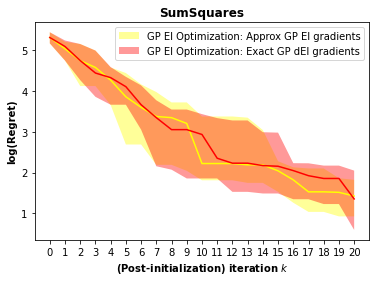

In [ ]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [ ]:
time_approx, time_exact

(177.58724761009216, 275.9945185184479)

In [ ]:
exact21_results, exact21_results[19:20].index[0]


(           0
 5   3.332840
 1   2.811135
 19  2.228860
 18  2.169766
 4   2.047086
 7   1.922399
 8   1.854486
 9   1.526867
 6   1.486688
 12  1.353468
 13  1.345923
 10  1.227980
 0   1.127634
 3   0.747839
 11  0.594533
 14  0.517614
 2   0.401465
 16 -0.261653
 15 -0.664629
 17 -1.359150, 17)

In [ ]:
str_exact = str(exact21_results[19:20].index[0]+1)
str_exact


'18'

In [ ]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-5.734141920432893, -9.068704890807851, 1.7464381178407749)

In [ ]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.00748483 0.10906747]	 -9.068756459576363	 -9.068756459576363	    
init	 [ 7.57202942 -6.36319549]	 -138.3161432668939	 -9.068756459576363	    
init	 [7.04466137 5.00272572]	 -99.6817831686958	 -9.068756459576363	    
init	 [3.32203335 9.75790897]	 -201.4694803352836	 -9.068756459576363	    
init	 [-4.86063155 -9.43388149]	 -201.6219791510955	 -9.068756459576363	    
1  	 [-6.1664519   4.28513481]	 -74.74988979878172	 -9.068756459576363	 -9.068757632343194
2  	 [-6.07110106 -2.27098711]	 -47.173032968123124	 -9.068756459576363	 -9.068757631067125
3  	 [-10.  10.]	 -300.0	 -9.068756459576363	 -9.068757632343194
4  	 [-2.33775535  8.28880862]	 -142.8737966101193	 -9.068756459576363	 -9.068757555603298
5  	 [ 4.59940623 -9.59713586]	 -205.36457092968183	 -9.068756459576363	 -9.068757632343194
6  	 [-0.77788299 -4.73427196]	 -45.431763852455845	 -9.068756459576363	 -9.068756281092632
7  	 [10. 10.]	 -

In [ ]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[ 1.95540328, -6.99948959],
        [-4.94473535,  6.85034403],
        [ 0.78225643,  1.71927247],
        [-9.56357267,  6.14012871],
        [-0.97078982, -9.30980012],
        [-9.74695034,  5.53052038],
        [-3.66522478, 10.        ],
        [ 6.86484526, -2.71517118],
        [ 0.12221261, -1.43602067],
        [10.        ,  3.17913615],
        [-4.32767777, -8.6640342 ],
        [ 1.95045693, -6.99888844],
        [-8.06302971, -9.86973108],
        [-9.49362916, -9.87083803],
        [ 6.68925551,  8.51972895],
        [-2.30048156, -7.40159711],
        [ 4.28917431,  3.6436621 ],
        [ 0.78196919,  1.71956428],
        [10.        , -7.15151722],
        [ 6.88024189, -2.69386201]]),
 array([-5.74, -5.73, -5.73, -5.74, -0.  , -5.74, -5.47, -5.74, -5.74,
        -5.74, -0.  , -5.74, -0.  , -0.  , -5.74, -5.74, -5.73, -5.73,
        -5.72, -5.74]),
 array([-9.74695034,  5.53052038]),
 array([-9.74695034,  5.53052038]))

In [ ]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_minAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_simpleRegret


(-0.2568790037829701, -8.952564864019832, -1.3591501073500598)

In [ ]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.00748483 0.10906747]	 -9.068756459576363	 -9.068756459576363	    
init	 [ 7.57202942 -6.36319549]	 -138.3161432668939	 -9.068756459576363	    
init	 [7.04466137 5.00272572]	 -99.6817831686958	 -9.068756459576363	    
init	 [3.32203335 9.75790897]	 -201.4694803352836	 -9.068756459576363	    
init	 [-4.86063155 -9.43388149]	 -201.6219791510955	 -9.068756459576363	    
1  	 [-6.1664519   4.28513481]	 -74.74988979878172	 -9.068756459576363	 -9.068757622339971
2  	 [-6.07110106 -2.27098711]	 -47.173032968123124	 -9.068756459576363	 -9.068757621063904
3  	 [10. 10.]	 -300.0	 -9.068756459576363	 -9.06875762233635
4  	 [-2.33775535  8.28880862]	 -142.8737966101193	 -9.068756459576363	 -9.068757545600077
5  	 [ 4.59940623 -9.59713586]	 -205.36457092968183	 -9.068756459576363	 -9.068757622339971
6  	 [-0.88286482 -3.88085007]	 -30.90144485825495	 -9.068756459576363	 -9.068747575366846
7  	 [10.         -0.

In [ ]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned


(array([[  0.55405353,  -6.33618934],
        [ -5.40558485,   7.20023845],
        [ -0.03982415,  -0.17323241],
        [ -8.6883636 ,   3.37572149],
        [ -0.97078982,  -9.30980012],
        [ -9.88021373,   4.47057794],
        [ -3.81425184,   8.99118934],
        [  1.63720485,  -1.97058366],
        [  0.03170498,  -0.35768268],
        [ 10.        ,   6.20634763],
        [ -4.32767777,  -8.6640342 ],
        [  3.31688901,  -5.18822444],
        [ -8.06302971,  -9.86973108],
        [ -9.62337213, -10.        ],
        [  6.56718641,   9.34193399],
        [ -1.84282847,  -6.63635723],
        [  5.15164684,   3.18976976],
        [  0.88122862,  -1.34586403],
        [ -1.58409273,  -6.56350557],
        [ -0.54596191,   0.49494044]]),
 array([-6.73, -8.31, -8.94, -7.12, -0.  , -8.92, -0.  , -8.64, -8.95,
        -8.65, -0.  , -0.  , -6.07, -0.12, -8.25, -8.1 , -2.51, -8.77,
        -7.85, -8.61]),
 array([ 0.03170498, -0.35768268]),
 array([ 0.03170498, -0.35768268]))

In [ ]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: y-value is greater

True

In [ ]:
eval_exactMinIQR_minAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc # Exact gradients' model: best AcqFunc is greater


True

In [ ]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log is lower


True

In [ ]:
eval_exactMinIQR_minAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc, eval_exactMinIQR_minAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_minAcqFunc


(-8.952564864019832, -9.068704890807851, 0.9871933172171321)

In [ ]:
### MinAcqFunc Comparison: Approximate Gradients

approx_1minAcqFunc = approx_1.history[:-1][1::2]
approx_2minAcqFunc = approx_2.history[:-1][1::2]
approx_3minAcqFunc = approx_3.history[:-1][1::2]
approx_4minAcqFunc = approx_4.history[:-1][1::2]
approx_5minAcqFunc = approx_5.history[:-1][1::2]
approx_6minAcqFunc = approx_6.history[:-1][1::2]
approx_7minAcqFunc = approx_7.history[:-1][1::2]
approx_8minAcqFunc = approx_8.history[:-1][1::2]
approx_9minAcqFunc = approx_9.history[:-1][1::2]
approx_10minAcqFunc = approx_10.history[:-1][1::2]
approx_11minAcqFunc = approx_11.history[:-1][1::2]
approx_12minAcqFunc = approx_12.history[:-1][1::2]
approx_13minAcqFunc = approx_13.history[:-1][1::2]
approx_14minAcqFunc = approx_14.history[:-1][1::2]
approx_15minAcqFunc = approx_15.history[:-1][1::2]
approx_16minAcqFunc = approx_16.history[:-1][1::2]
approx_17minAcqFunc = approx_17.history[:-1][1::2]
approx_18minAcqFunc = approx_18.history[:-1][1::2]
approx_19minAcqFunc = approx_19.history[:-1][1::2]
approx_20minAcqFunc = approx_20.history[:-1][1::2]


In [ ]:
### MinAcqFunc Comparison: Exact Gradients

exact_1minAcqFunc = exact_1.history[:-1][1::2]
exact_2minAcqFunc = exact_2.history[:-1][1::2]
exact_3minAcqFunc = exact_3.history[:-1][1::2]
exact_4minAcqFunc = exact_4.history[:-1][1::2]
exact_5minAcqFunc = exact_5.history[:-1][1::2]
exact_6minAcqFunc = exact_6.history[:-1][1::2]
exact_7minAcqFunc = exact_7.history[:-1][1::2]
exact_8minAcqFunc = exact_8.history[:-1][1::2]
exact_9minAcqFunc = exact_9.history[:-1][1::2]
exact_10minAcqFunc = exact_10.history[:-1][1::2]
exact_11minAcqFunc = exact_11.history[:-1][1::2]
exact_12minAcqFunc = exact_12.history[:-1][1::2]
exact_13minAcqFunc = exact_13.history[:-1][1::2]
exact_14minAcqFunc = exact_14.history[:-1][1::2]
exact_15minAcqFunc = exact_15.history[:-1][1::2]
exact_16minAcqFunc = exact_16.history[:-1][1::2]
exact_17minAcqFunc = exact_17.history[:-1][1::2]
exact_18minAcqFunc = exact_18.history[:-1][1::2]
exact_19minAcqFunc = exact_19.history[:-1][1::2]
exact_20minAcqFunc = exact_20.history[:-1][1::2]


In [ ]:
### MinAcqFunc Comparison: Experiment 1

minAcqFuncApprox1 = np.mean(approx_1minAcqFunc)
minAcqFuncExact1 = np.mean(exact_1minAcqFunc)
ratio1 = minAcqFuncApprox1/minAcqFuncExact1
approx_1.tau, exact_1.tau, minAcqFuncApprox1, minAcqFuncExact1, ratio1


(-4.326653764360808,
 -3.0883423221235793,
 -5.284044193031587,
 -4.980638281737798,
 1.0609170741039895)

In [ ]:
### MinAcqFunc Comparison: Experiment 2

minAcqFuncApprox2 = np.mean(approx_2minAcqFunc)
minAcqFuncExact2 = np.mean(exact_2minAcqFunc)
ratio2 = minAcqFuncApprox2/minAcqFuncExact2
approx_2.tau, exact_2.tau, minAcqFuncApprox2, minAcqFuncExact2, ratio2


(-4.333099000920773,
 -4.333099000920773,
 -4.328925942621714,
 -4.321401181454825,
 1.0017412780834098)

In [ ]:
### MinAcqFunc Comparison: Experiment 3

minAcqFuncApprox3 = np.mean(approx_3minAcqFunc)
minAcqFuncExact3 = np.mean(exact_3minAcqFunc)
ratio3 = minAcqFuncApprox3/minAcqFuncExact3
approx_3.tau, exact_3.tau, minAcqFuncApprox3, minAcqFuncExact3, ratio3


(-1.4940122574729555,
 -1.4940122574729555,
 -7.28223663062123,
 -7.269331296189264,
 1.0017753124608217)

In [ ]:
### MinAcqFunc Comparison: Experiment 4

minAcqFuncApprox4 = np.mean(approx_4minAcqFunc)
minAcqFuncExact4 = np.mean(exact_4minAcqFunc)
ratio4 = minAcqFuncApprox4/minAcqFuncExact4
approx_4.tau, exact_4.tau, minAcqFuncApprox4, minAcqFuncExact4, ratio4


(-3.569635087520078,
 -2.112430794758758,
 -12.15689640890697,
 -11.189073219939932,
 1.0864971718338827)

In [ ]:
### MinAcqFunc Comparison: Experiment 5

minAcqFuncApprox5 = np.mean(approx_5minAcqFunc)
minAcqFuncExact5 = np.mean(exact_5minAcqFunc)
ratio5 = minAcqFuncApprox5/minAcqFuncExact5
approx_5.tau, exact_5.tau, minAcqFuncApprox5, minAcqFuncExact5, ratio5


(-9.736075067806567,
 -7.745296250806153,
 -9.901397582445316,
 -9.447456326852267,
 1.0480490451490974)

In [ ]:
### MinAcqFunc Comparison: Experiment 6

minAcqFuncApprox6 = np.mean(approx_6minAcqFunc)
minAcqFuncExact6 = np.mean(exact_6minAcqFunc)
ratio6 = minAcqFuncApprox6/minAcqFuncExact6
approx_6.tau, exact_6.tau, minAcqFuncApprox6, minAcqFuncExact6, ratio6


(-3.2663604079401702,
 -5.629416961321397,
 -5.618656889036034,
 -5.59884679282507,
 1.0035382458109678)

In [ ]:
### MinAcqFunc Comparison: Experiment 7

minAcqFuncApprox7 = np.mean(approx_7minAcqFunc)
minAcqFuncExact7 = np.mean(exact_7minAcqFunc)
ratio7 = minAcqFuncApprox7/minAcqFuncExact7
approx_7.tau, exact_7.tau, minAcqFuncApprox7, minAcqFuncExact7, ratio7


(-1.1339220737572815,
 -4.422426167951279,
 -13.063944372977542,
 -16.20356948414899,
 0.806238673877212)

In [ ]:
### MinAcqFunc Comparison: Experiment 8

minAcqFuncApprox8 = np.mean(approx_8minAcqFunc)
minAcqFuncExact8 = np.mean(exact_8minAcqFunc)
ratio8 = minAcqFuncApprox8/minAcqFuncExact8
approx_8.tau, exact_8.tau, minAcqFuncApprox8, minAcqFuncExact8, ratio8


(-0.5791878792948744,
 -0.5791878792948744,
 -1.1185903221953821,
 -1.1139527356826984,
 1.0041631806845392)

In [ ]:
### MinAcqFunc Comparison: Experiment 9

minAcqFuncApprox9 = np.mean(approx_9minAcqFunc)
minAcqFuncExact9 = np.mean(exact_9minAcqFunc)
ratio9 = minAcqFuncApprox9/minAcqFuncExact9
approx_9.tau, exact_9.tau, minAcqFuncApprox9, minAcqFuncExact9, ratio9


(-3.5258239489091197,
 -6.388412071319043,
 -21.023997273186232,
 -15.676673929509453,
 1.341100629363164)

In [ ]:
### MinAcqFunc Comparison: Experiment 10

minAcqFuncApprox10 = np.mean(approx_10minAcqFunc)
minAcqFuncExact10 = np.mean(exact_10minAcqFunc)
ratio10 = minAcqFuncApprox10/minAcqFuncExact10
approx_10.tau, exact_10.tau, minAcqFuncApprox10, minAcqFuncExact10, ratio10


(-4.603728884330075,
 -4.603728884330075,
 -9.809634910996165,
 -9.792611534230554,
 1.0017383898775218)

In [ ]:
### MinAcqFunc Comparison: Experiment 11

minAcqFuncApprox11 = np.mean(approx_11minAcqFunc)
minAcqFuncExact11 = np.mean(exact_11minAcqFunc)
ratio11 = minAcqFuncApprox11/minAcqFuncExact11
approx_11.tau, exact_11.tau, minAcqFuncApprox11, minAcqFuncExact11, ratio11


(-2.716881462565864,
 -2.716881462565864,
 -2.784416058490703,
 -2.7603420722418504,
 1.0087213778650632)

In [ ]:
### MinAcqFunc Comparison: Experiment 12

minAcqFuncApprox12 = np.mean(approx_12minAcqFunc)
minAcqFuncExact12 = np.mean(exact_12minAcqFunc)
ratio12 = minAcqFuncApprox12/minAcqFuncExact12
approx_12.tau, exact_12.tau, minAcqFuncApprox12, minAcqFuncExact12, ratio12


(-2.256892556058838,
 -1.8121839738384036,
 -16.029173122137866,
 -10.218549812303467,
 1.5686348275014739)

In [ ]:
### MinAcqFunc Comparison: Experiment 13

minAcqFuncApprox13 = np.mean(approx_13minAcqFunc)
minAcqFuncExact13 = np.mean(exact_13minAcqFunc)
ratio13 = minAcqFuncApprox13/minAcqFuncExact13
approx_13.tau, exact_13.tau, minAcqFuncApprox13, minAcqFuncExact13, ratio13


(-6.428195520869893,
 -3.8708263682458,
 -16.677108919148345,
 -18.702102612381413,
 0.8917237416988368)

In [ ]:
### MinAcqFunc Comparison: Experiment 14

minAcqFuncApprox14 = np.mean(approx_14minAcqFunc)
minAcqFuncExact14 = np.mean(exact_14minAcqFunc)
ratio14 = minAcqFuncApprox14/minAcqFuncExact14
approx_14.tau, exact_14.tau, minAcqFuncApprox14, minAcqFuncExact14, ratio14


(-0.3534375557853193,
 -3.8417313054871873,
 -15.190806499384816,
 -17.420587916958237,
 0.8720030903547854)

In [ ]:
### MinAcqFunc Comparison: Experiment 15

minAcqFuncApprox15 = np.mean(approx_15minAcqFunc)
minAcqFuncExact15 = np.mean(exact_15minAcqFunc)
ratio15 = minAcqFuncApprox15/minAcqFuncExact15
approx_15.tau, exact_15.tau, minAcqFuncApprox15, minAcqFuncExact15, ratio15


(-2.3695015423710775,
 -1.678019658304552,
 -9.552861723514768,
 -12.906967195713639,
 0.7401321765726067)

In [ ]:
### MinAcqFunc Comparison: Experiment 16

minAcqFuncApprox16 = np.mean(approx_16minAcqFunc)
minAcqFuncExact16 = np.mean(exact_16minAcqFunc)
ratio16 = minAcqFuncApprox16/minAcqFuncExact16
approx_16.tau, exact_16.tau, minAcqFuncApprox16, minAcqFuncExact16, ratio16


(-4.548581261481097,
 -0.5144642715556319,
 -17.014394748859353,
 -13.064454037618654,
 1.3023425777967435)

In [ ]:
### MinAcqFunc Comparison: Experiment 17

minAcqFuncApprox17 = np.mean(approx_17minAcqFunc)
minAcqFuncExact17 = np.mean(exact_17minAcqFunc)
ratio17 = minAcqFuncApprox17/minAcqFuncExact17
approx_17.tau, exact_17.tau, minAcqFuncApprox17, minAcqFuncExact17, ratio17


(-4.156213791773137,
 -0.7697779197533032,
 -10.322632811622409,
 -11.041603692538141,
 0.9348852846981269)

In [ ]:
### MinAcqFunc Comparison: Experiment 18

minAcqFuncApprox18 = np.mean(approx_18minAcqFunc)
minAcqFuncExact18 = np.mean(exact_18minAcqFunc)
ratio18 = minAcqFuncApprox18/minAcqFuncExact18
approx_18.tau, exact_18.tau, minAcqFuncApprox18, minAcqFuncExact18, ratio18


(-5.734141920432893,
 -0.2568790037829701,
 -7.395979870056481,
 -9.057880783231306,
 0.816524311486692)

In [ ]:
### MinAcqFunc Comparison: Experiment 19

minAcqFuncApprox19 = np.mean(approx_19minAcqFunc)
minAcqFuncExact19 = np.mean(exact_19minAcqFunc)
ratio19 = minAcqFuncApprox19/minAcqFuncExact19
approx_19.tau, exact_19.tau, minAcqFuncApprox19, minAcqFuncExact19, ratio19


(-2.524157178764308,
 -8.756231898391391,
 -16.458761182256602,
 -20.48619141476257,
 0.8034075660542859)

In [ ]:
### MinAcqFunc Comparison: Experiment 20

minAcqFuncApprox20 = np.mean(approx_20minAcqFunc)
minAcqFuncExact20 = np.mean(exact_20minAcqFunc)
ratio20 = minAcqFuncApprox20/minAcqFuncExact20
approx_20.tau, exact_20.tau, minAcqFuncApprox20, minAcqFuncExact20, ratio20


(-6.161449614183514,
 -6.161449614183514,
 -6.15112719319897,
 -6.146632077502173,
 1.000731313610465)

In [ ]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMinAcqFuncExact = [minAcqFuncExact1,minAcqFuncExact2,minAcqFuncExact3,minAcqFuncExact4,minAcqFuncExact5,minAcqFuncExact6,minAcqFuncExact7,minAcqFuncExact8,minAcqFuncExact9,minAcqFuncExact10,minAcqFuncExact11,minAcqFuncExact12,minAcqFuncExact13,minAcqFuncExact14,minAcqFuncExact15,minAcqFuncExact16,minAcqFuncExact17,minAcqFuncExact18,minAcqFuncExact19,minAcqFuncExact20]
AvgMinAcqFuncApprox = [minAcqFuncApprox1,minAcqFuncApprox2,minAcqFuncApprox3,minAcqFuncApprox4,minAcqFuncApprox5,minAcqFuncApprox6,minAcqFuncApprox7,minAcqFuncApprox8,minAcqFuncApprox9,minAcqFuncApprox10,minAcqFuncApprox11,minAcqFuncApprox12,minAcqFuncApprox13,minAcqFuncApprox14,minAcqFuncApprox15,minAcqFuncApprox16,minAcqFuncApprox17,minAcqFuncApprox18,minAcqFuncApprox19,minAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [ ]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMinAcqFuncExact, AvgMinAcqFuncApprox)


In [ ]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [ ]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMinAcqFuncExact=AvgMinAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMinAcqFuncApprox=AvgMinAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &  ExactTau &  ApproxTau &  AvgMinAcqFuncExact & GreaterAcqFunc &  AvgMinAcqFuncApprox &    Ratio & GreaterRatio \\
\midrule
         18 & -0.256879 &  -5.734142 &           -9.057881 &             No &            -7.395980 & 0.816524 &           No \\
         16 & -0.514464 &  -4.548581 &          -13.064454 &            Yes &           -17.014395 & 1.302343 &          Yes \\
          8 & -0.579188 &  -0.579188 &           -1.113953 &            Yes &            -1.118590 & 1.004163 &          Yes \\
         17 & -0.769778 &  -4.156214 &          -11.041604 &             No &           -10.322633 & 0.934885 &           No \\
          3 & -1.494012 &  -1.494012 &           -7.269331 &            Yes &            -7.282237 & 1.001775 &          Yes \\
         15 & -1.678020 &  -2.369502 &          -12.906967 &             No &            -9.552862 & 0.740132 &           No \\
         12 & -1.812184 &  -2.256893 &          -10.218550 &

In [ ]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMinAcqFuncExact','AvgMinAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMinAcqFuncExact,GreaterAcqFunc,AvgMinAcqFuncApprox,Ratio,GreaterRatio
17,18.0,-0.256879,-5.734142,-9.057881,No,-7.395980,0.816524,No
15,16.0,-0.514464,-4.548581,-13.064454,Yes,-17.014395,1.302343,Yes
7,8.0,-0.579188,-0.579188,-1.113953,Yes,-1.118590,1.004163,Yes
16,17.0,-0.769778,-4.156214,-11.041604,No,-10.322633,0.934885,No
2,3.0,-1.494012,-1.494012,-7.269331,Yes,-7.282237,1.001775,Yes
14,15.0,-1.678020,-2.369502,-12.906967,No,-9.552862,0.740132,No
11,12.0,-1.812184,-2.256893,-10.218550,Yes,-16.029173,1.568635,Yes
3,4.0,-2.112431,-3.569635,-11.189073,Yes,-12.156896,1.086497,Yes
10,11.0,-2.716881,-2.716881,-2.760342,Yes,-2.784416,1.008721,Yes
0,1.0,-3.088342,-4.326654,-4.980638,Yes,-5.284044,1.060917,Yes


In [140]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 1.043
Ratio of Average AvgMinAcqFuncExact to Average AvgMinAcqFuncApprox: 0.99888
Number of experiments where AvgMinAcqFuncExact exceeds AvgMinAcqFuncApprox: 13
Number of experiments where Ratio exceeds 1.0: 13
